In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [3]:
ts = data['#Passengers'] 
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


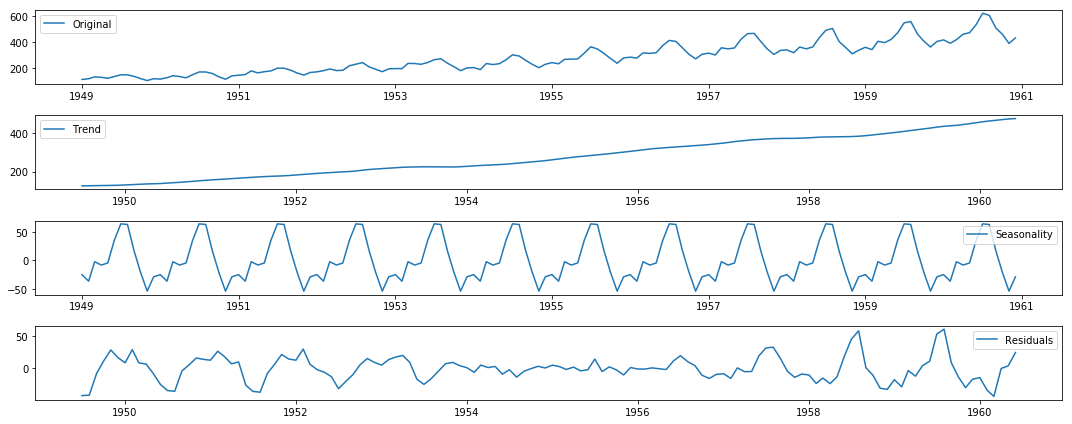

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [5]:
from statsmodels.tsa.stattools import adfuller
dftest=adfuller(ts, autolag='AIC')
dftest

(0.81536887920603984,
 0.99188024343764092,
 13L,
 130L,
 {'1%': -3.4816817173418295,
  '10%': -2.5787700591715979,
  '5%': -2.8840418343195267},
 996.69293083901903)

In [7]:
adfuller?

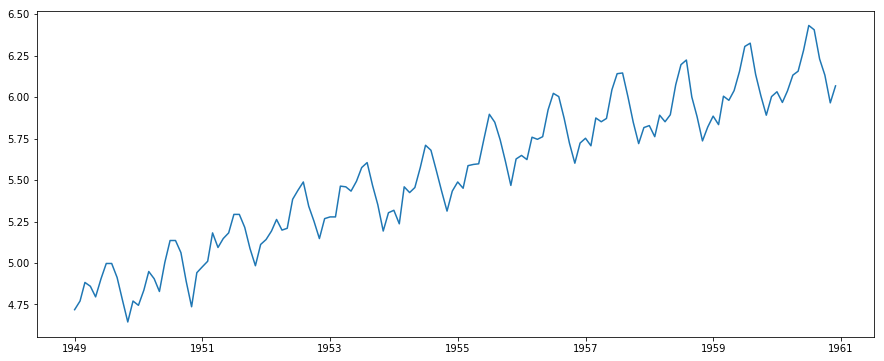

In [10]:
ts_log = np.log(ts)
plt.plot(ts_log)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


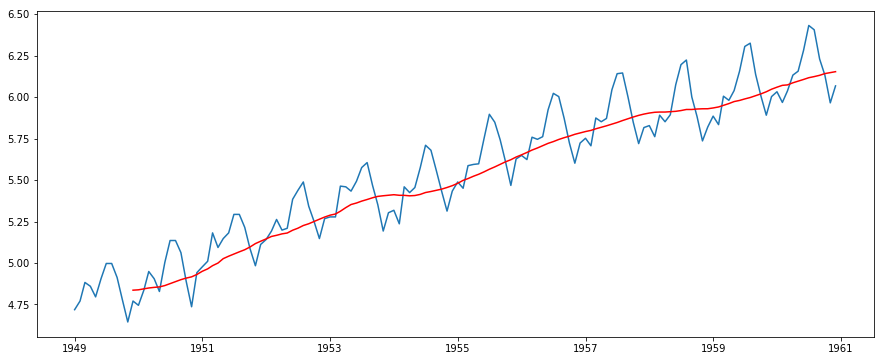

In [11]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

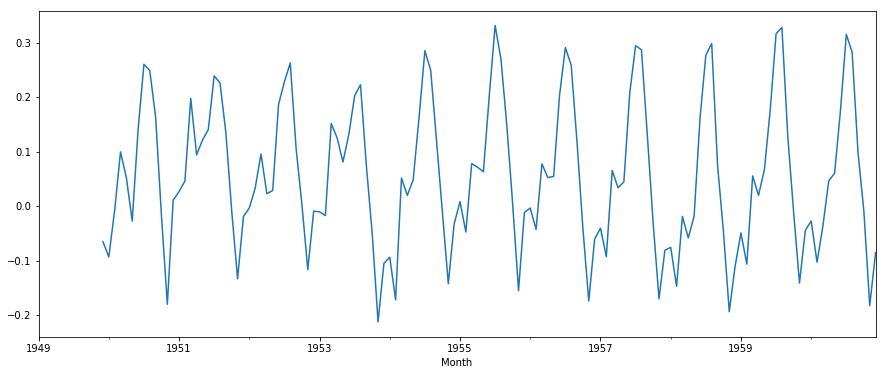

In [13]:
ts_log_moving_avg_diff.plot()

In [14]:
ts_log_moving_avg_diff.dropna(inplace=True)
dftest2=adfuller(ts_log_moving_avg_diff)
dftest2

(-3.1629079913008584,
 0.022234630001243823,
 13L,
 119L,
 {'1%': -3.4865346059036564,
  '10%': -2.5798960927900572,
  '5%': -2.8861509858476264},
 -436.63269481747125)

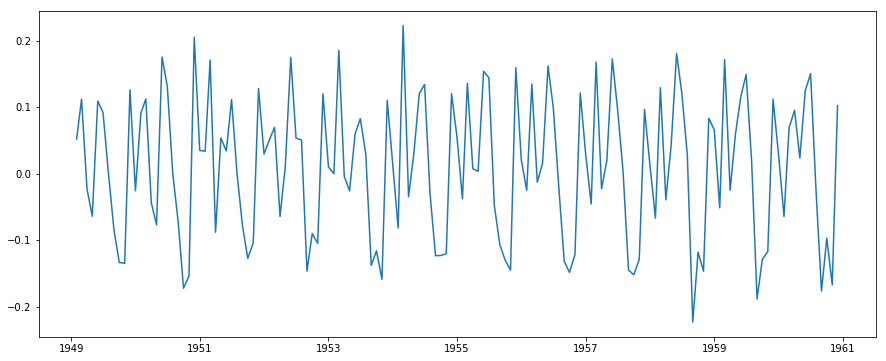

In [15]:
#eliminate trend & seasonality
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [17]:
ts_log_diff.dropna(inplace=True)
dftest3=adfuller(ts_log_diff)

In [18]:
dftest3

(-2.7171305983881475,
 0.071120548150856291,
 14L,
 128L,
 {'1%': -3.4825006939887997,
  '10%': -2.5789601977539061,
  '5%': -2.8843979841613772},
 -440.35846985568094)

In [20]:
#common method - ARIMA (Autoregressive integrated Moving Average)
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12, method='ols')

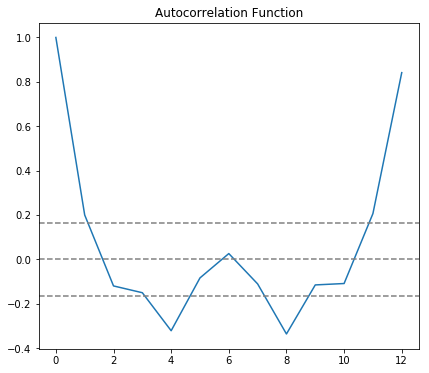

In [21]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

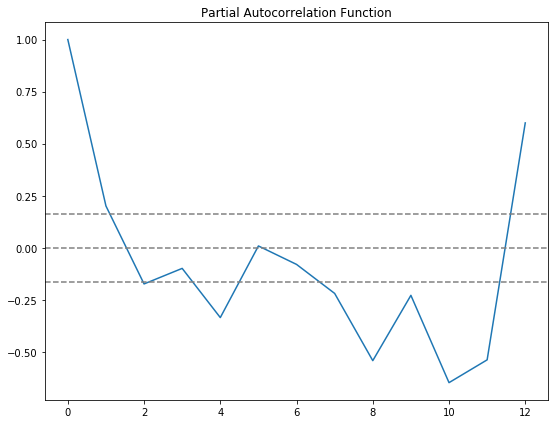

In [22]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

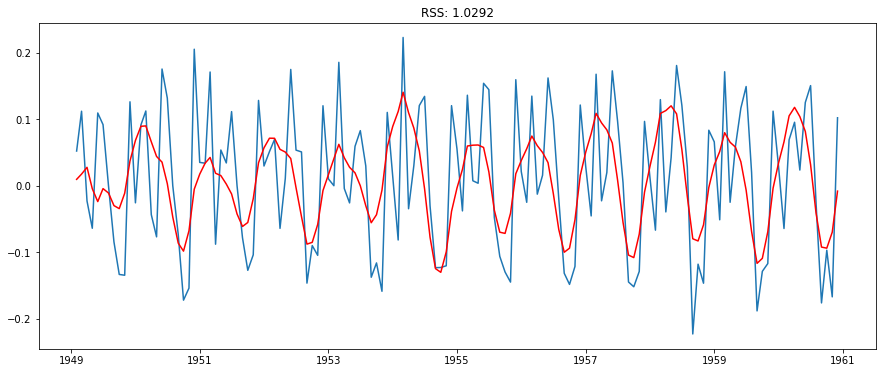

In [23]:
# AR Model
#We need to load the ARIMA model first:
from statsmodels.tsa.arima_model import ARIMA

model1 = ARIMA(ts_log, order=(2, 1, 0))  #RSS=1.5
model2 = ARIMA(ts_log, order=(0, 1, 2))  #RSS=1.4
model = ARIMA(ts_log, order=(2, 1, 2))  #RSS=1
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [27]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Sat, 29 Apr 2017   AIC                           -287.281
Time:                        16:49:58   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passeng

In [35]:
results_AR.forecast?

In [24]:
forecast_4months=results_AR.forecast(steps=4)

In [25]:
np.exp(forecast_4months[0])

array([ 443.87097084,  470.0382234 ,  504.93496984,  540.45479819])

In [26]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [30]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [31]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

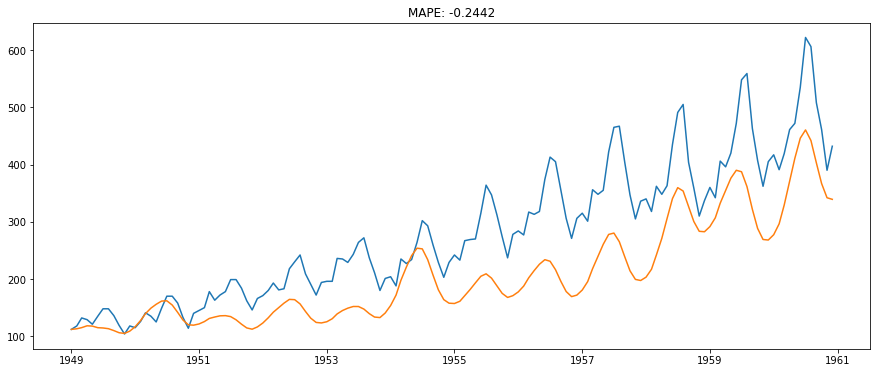

In [45]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
plt.title('MAPE: %.4f'% np.mean((predictions_ARIMA-ts)/ts))